In [12]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from scipy.optimize import minimize 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from time import time

In [9]:
# Function for displaying the digits

def displayData(X,nameFig):
    
    m,n = X.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)
    
    #Compute number of items to display
    
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)
    
    # Between images padding
    pad = 1
    
    # Setup blank display
    display_array = -np.ones((pad + display_rows * (example_height + pad),pad + display_cols * (example_width + pad)))

    # Copy each example into a patch on the display array
    
    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex > m: 
                break 
            # Copy the patch
            # Get the max value of the patch
            max_val = max(np.abs(X[curr_ex]))
            rowStart = pad+j*(example_height+pad)
            colStart = pad+i*(example_width+pad)
            display_array[rowStart:rowStart+example_height, colStart:colStart+example_width] = X[curr_ex,:].reshape((example_height,example_width)).T/max_val
           
            curr_ex = curr_ex + 1
        if curr_ex > m: 
            break
    
    plt.imshow(display_array,cmap = plt.cm.Greys_r)
    plt.axis('off')
    plt.savefig(nameFig)


In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [5]:
# Function to return cost of the logistic regression model

def costFunction(theta,X,y,lamb):
    
    m,n=X.shape

    first = np.dot(y.T,np.log(sigmoid(np.dot(X,theta))))
    second = np.dot((1-y).T,np.log(1-sigmoid(np.dot(X,theta))))
    
    # calculating and adding regularization term to the cost function 
    reg = (lamb/(2*m))*(np.sum((theta[1:])**2))
    J = (first+second)/(-m)+reg
    
    return J  

In [6]:
# Function to return gradient of logistic regression cost

def Fungradient(theta,X,y,lamb):
    
    m,n=X.shape
    theta = theta.reshape((n,1))
    
    grad = np.zeros((theta.shape))
    
    error = sigmoid(np.dot(X,theta)) - y
    grad[0] = (np.dot(np.ones((1,m)),error))/m
    grad[1:] = (np.dot(X[:,1:].T,error))/m + (lamb/m)*theta[1:]
    
    return grad

In [7]:
# Function to return paramters theta for one-vs-all logistic regression

def oneVsAll(X, y, num_labels, lamb):
    
    # ONEVSALL trains multiple logistic regression classifiers and returns all
    # the classifiers in a matrix all_theta, where the i-th row of all_theta 
    # corresponds to the classifier for label i
    
    # Some useful variables
    m,n = X.shape
    
    # need to return the following variables correctly 
    all_theta = np.zeros((num_labels, n + 1))
    
    # Add ones to the X data matrix
    X = np.hstack((np.ones((m,1)),X))

    for k in range(num_labels):
        ini_theta = np.zeros((n+1,1))

        y_k = np.array([1 if num_labels == k else 0 for num_labels in y])
        y_k = np.reshape(y_k, (m, 1))
        
        # using advanced optimization techniques to minimize cost function and return the relevant weights 
        fmin = minimize(fun=costFunction, x0=ini_theta, args=(X, y_k, lamb), method='TNC', jac=Fungradient)
        all_theta[k,:] = fmin.x
    
    return all_theta

In [8]:
# function to predict digits with maximum probability for given feature vector and weights ('theta')

def predictOneVsAll(all_theta, X):
    
    m,n = X.shape
    
    num_labels = all_theta.shape[0]
    
    # need to return the following variable correctly 
    p = np.zeros((m, 1))
    
    # Add ones to the X data matrix
    X = np.hstack((np.ones((m,1)),X))
    
    # compute the class probability for each class on each training instance
    h = sigmoid(np.dot(X,all_theta.T))
    
    # create array of the index with the maximum probability
    p = np.argmax(h,axis=1)
    
    return p

## A. Loading and Visualizing data

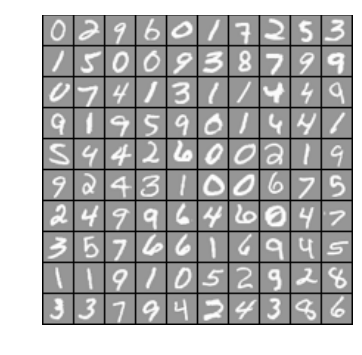

In [11]:
data = sio.loadmat('ex3data1.mat')

X = data['X']
y = data['y']
y[y==10] = 0 
m,n = X.shape

rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100]]

# displaying 100 random digits and saving the display to the output
displayData(sel,'DigitsLogis1')

### B. Implementing Vectorized Logistic Regression


Training One-vs-All Logistic Regression...

The Training accuracy for learning rate 0.1 is 96.90%
The cross validation accuracy for learning rate 0.1 is 89.60%

The Training accuracy for learning rate 0.3 is 96.15%
The cross validation accuracy for learning rate 0.3 is 90.30%

The Training accuracy for learning rate 1 is 94.83%
The cross validation accuracy for learning rate 1 is 90.90%

The Training accuracy for learning rate 3 is 93.97%
The cross validation accuracy for learning rate 3 is 90.40%

The Training accuracy for learning rate 9 is 92.30%
The cross validation accuracy for learning rate 9 is 89.80%


Total time taken to Train the logistic regression: 114.801s

Time taken to make prediction for the logistic regression: 0.148s


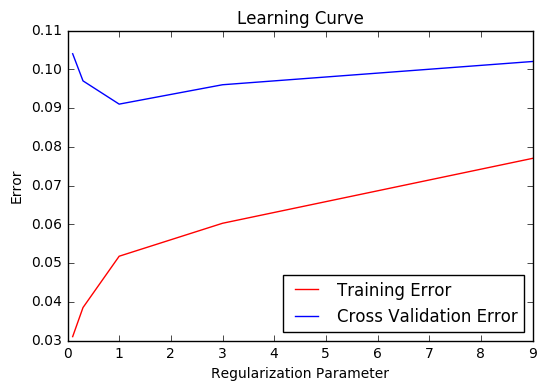

In [18]:
print('\nTraining One-vs-All Logistic Regression...\n')

X_train, X_CV, y_train, y_CV = train_test_split(X,y,test_size=0.2, random_state = 0) 

num_labels = 10  # for digits [0-9]

# initializing the regularization paramter 
learning_rate = [0.1,0.3,1,3,9]

train_error = []
CV_error = []
accuracyCV = 0
accuracytrain = 0
best_accuracyCV = 0
best_accuracyTrain = 0
best_learningrate = 0

''' 
run the loop for different regularization and then using cross validation to determine the best regularization 
parameter for which the cross validation accuracy is maximum
'''
time_start_loop = time()
time_loop = []
for l in learning_rate:
    
    t0 = time()
    # training the algorithm and learning the weights 
    all_theta = oneVsAll(X_train, y_train, num_labels, l)
    
    t_train = time()-t0
    time_loop.append(t_train)
    
    # Using the weights obtained in above line to make cross validation and training predications
    CVpred = predictOneVsAll(all_theta, X_CV)
    trainpred = predictOneVsAll(all_theta,X_train)
    
    # Finding cross validation and training datasets accuracy
    
    correctCV = [1 if a == b else 0 for (a, b) in zip(CVpred, y_CV)]  
    accuracyCV = (sum(map(int, correctCV)) / float(len(correctCV)))
    
    correctTrain = [1 if a == b else 0 for (a, b) in zip(trainpred, y_train)]  
    accuracyTrain = (sum(map(int, correctTrain)) / float(len(correctTrain)))

    # Finding cross validation and training datasets error
    incorrectCV = [0 if a == b else 1 for (a, b) in zip(CVpred, y_CV)]  
    errorCV = (sum(map(int, incorrectCV)) / float(len(incorrectCV)))
    CV_error.append(errorCV)
    
    incorrectTrain = [0 if a == b else 1 for (a, b) in zip(trainpred, y_train)]  
    errorTrain = (sum(map(int, incorrectTrain)) / float(len(incorrectTrain)))
    train_error.append(errorTrain)
    
    
    if accuracyCV>best_accuracyCV:
        best_accuracyCV = accuracyCV
        best_accuracyTrain = accuracyTrain
        best_learningrate = l
        best_theta = all_theta
    
    print("The Training accuracy for learning rate {} is {:.2f}%".format(l,accuracyTrain*100))
    print("The cross validation accuracy for learning rate {} is {:.2f}%\n".format(l,accuracyCV*100))

time_end_loop = time()

print("\nTotal time taken to Train the logistic regression: {:.3f}s".format(sum(time_loop)))
print("\nTime taken to make prediction for the logistic regression: {:.3f}s".format((time_end_loop-time_start_loop)-sum(time_loop)))

plt.plot(learning_rate,train_error,'r',label='Training Error')
plt.plot(learning_rate,CV_error,'b',label = 'Cross Validation Error')
plt.title('Learning Curve')
plt.xlabel('Regularization Parameter')
plt.ylabel('Error')
plt.legend(loc=4)
plt.savefig('learning_curve_logisticRegression.png')